# Bidiagonalization

We have an SVD subproblem, which is a block matrix with diagonal entries and dense last row (or last column) entries. The last row or column is because we augmented a singular values matrix from an arbitrary data matrix, with one appended row/column (Ross 2008). The paper did not state how to solve this SVD, which is the same size as a (square) original problem matrix. We can walk values up the off-diagonals, using different Householder reflections on each side of the matrix, in O(n^2) time. This could be implemented for cache locality, with a diagonal, off-diagonal, and blockrow mutable arrays, and one local variable for the temp non-zero entry and its location.

When we reach a steady-state for large matrix, each walk (Householder matrix) will either flip the temp entry (with new value) left two columns and down one row, or right one column and up two rows. The procedure is started n times, for 

The bidiagonal matrix B is not similar to the sparse matrix A, because different orthogonal matrices were multiplied on its left and right side. However, the Gram matrix B^T B is tridiagonal and symmetric (useful form for determining all eigenvalues), and it is similar to A^T A because the particular orthogonal matrix and its transpose on the inside of the product cancel out. The eigenvectors of A^T A (if the inversion steps on one side of the matrix are noted) are the right singular vectors of A.

Complete square SVD (or all eigenvalues and all right singular vectors) might be somewhat more complex than O(n^2). The sparse matrix storage is O(n), so it would be interesting to improve on this particular decomposition and limit use of the algorithm downstream from it (QR algorithm).

References:

Ross, D.A., Lim, J., Lin, RS. et al. Incremental Learning for Robust Visual Tracking. Int J Comput Vis 77, 125–141 (2008). https://doi.org/10.1007/s11263-007-0075-7

In [3]:
import numpy as np
np.set_printoptions(precision=4, linewidth=150)

In [4]:
n = 5
A = np.diag(np.random.random(n))
A[-1, :] = np.random.random(n)
A, np.linalg.eig(A)[0]

(array([[0.0811, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.6711, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.2505, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.8938, 0.    ],
        [0.5882, 0.4211, 0.4942, 0.8935, 0.791 ]]),
 array([0.791 , 0.0811, 0.6711, 0.2505, 0.8938]))

In [29]:
def reflect(A, loc, inds, dest):
    v = A[loc].copy()
    inds_mask = np.zeros_like(v, bool)
    inds_mask[inds] = 1
    v[~inds_mask] = 0
    v[dest] += (1. if v[1] >= 0 else -1) * np.linalg.norm(v)
    v /= np.linalg.norm(v)
    mat = np.eye(len(v)) - 2 * v[:, None].dot(v[None, :])
    return A.dot(mat)

In [33]:
# We would like to meld A_43 with the diagonal, then continue sparsifying
# the matrix until only diagonal entries are left.
reflect(A.T, 3, [3, 4], 3).T

array([[ 8.1087e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  6.7111e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  2.5049e-01,  0.0000e+00,  0.0000e+00],
       [-4.1585e-01, -2.9769e-01, -3.4942e-01, -1.2638e+00, -5.5920e-01],
       [ 4.1601e-01,  2.9780e-01,  3.4955e-01, -1.9877e-16,  5.5941e-01]])

In [60]:
# This was unsuccessful, so let's try bidiagonal instead.
reflect(A, 4, [0, 1], 1)

array([[ 4.7199e-02, -6.5934e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-5.4570e-01, -3.9064e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  2.5049e-01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.9379e-01,  0.0000e+00],
       [ 8.4413e-17, -7.2339e-01,  4.9425e-01,  8.9347e-01,  7.9098e-01]])

In [36]:
A1 = reflect(A, 4, [0, 1], 1)
A1 = reflect(A1.T, 1, [0, 1], 1).T
A1

array([[ 1.3736e-01,  1.9392e-18,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 5.3023e-01,  3.9616e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  2.5049e-01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.9379e-01,  0.0000e+00],
       [ 8.4413e-17, -7.2339e-01,  4.9425e-01,  8.9347e-01,  7.9098e-01]])

In [56]:
A2 = reflect(A1, 4, [1, 2], 2)
A2 = reflect(A2.T, 2, [1, 2], 2).T
A2 = reflect(A2, 2, [0, 1], 1)
A2 = reflect(A2.T, 1, [0, 1], 1).T
A2

array([[ 1.2626e-01,  1.2388e-17, -1.6363e-18,  0.0000e+00,  0.0000e+00],
       [-1.8139e-01,  3.0299e-01, -2.9881e-19,  0.0000e+00,  0.0000e+00],
       [-5.9204e-17, -5.0209e-01,  3.5632e-01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.9379e-01,  0.0000e+00],
       [-5.7747e-17,  1.0168e-16,  8.7612e-01,  8.9347e-01,  7.9098e-01]])

In [62]:
A3 = reflect(A2, 4, [2, 3], 3)
A3 = reflect(A3.T, 3, [2, 3], 3).T
A3

array([[ 1.2626e-01,  1.2388e-17, -1.1683e-18,  1.1457e-18,  0.0000e+00],
       [-1.8139e-01,  3.0299e-01, -2.1335e-19,  2.0921e-19,  0.0000e+00],
       [ 5.5140e-17,  4.6762e-01, -4.6480e-01,  1.8039e-16,  0.0000e+00],
       [-2.1556e-17, -1.8281e-01, -4.9020e-01, -6.8520e-01,  0.0000e+00],
       [-5.7747e-17,  1.0168e-16,  1.2711e-16, -1.2513e+00,  7.9098e-01]])

In [63]:
A1 = reflect(A, 4, [0, 1], 1)
A1 = reflect(A1.T, 0, [1, 0], 0).T
A1

array([[ 5.4773e-01,  3.8350e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 1.0894e-16,  9.9351e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  2.5049e-01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.9379e-01,  0.0000e+00],
       [ 8.4413e-17, -7.2339e-01,  4.9425e-01,  8.9347e-01,  7.9098e-01]])

In [74]:
A2 = reflect(A1, 4, [1, 2], 2)
A2 = reflect(A2.T, 1, [2, 1], 1).T
A2 = reflect(A2.T, 2, [0, 1], 1).T
A2 = reflect(A2, 1, [0, 1], 1)
A2

array([[-2.2100e-01,  2.4868e-01, -7.5441e-19,  0.0000e+00,  0.0000e+00],
       [ 1.5945e-17, -5.3109e-01,  3.3687e-01,  0.0000e+00,  0.0000e+00],
       [-3.8899e-17, -9.8622e-17,  1.1614e-01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.9379e-01,  0.0000e+00],
       [-5.7747e-17,  1.0168e-16,  8.7612e-01,  8.9347e-01,  7.9098e-01]])

array([[-2.6710e-01, -3.9222e-01, -2.7944e-17,  9.5099e-18,  0.0000e+00],
       [ 7.3189e-18, -5.1471e-01,  2.6177e-01,  2.5433e-17,  0.0000e+00],
       [-1.5004e-17, -3.1007e-17, -5.3892e-01,  6.6518e-01,  0.0000e+00],
       [-2.1055e-17,  1.2433e-16, -4.2151e-17, -1.6444e-01,  0.0000e+00],
       [-6.4406e-17, -4.2108e-17, -1.5462e-16, -1.2513e+00,  7.9098e-01]])

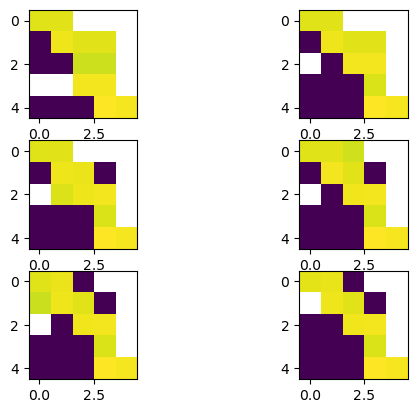

In [113]:
plt.subplot(3, 2, 1)
A3 = reflect(A2, 4, [2, 3], 3)
plt.imshow(np.abs(A3), norm=matplotlib.colors.LogNorm())
A3 = reflect(A3.T, 2, [3, 2], 2).T
plt.subplot(3, 2, 2)
plt.imshow(np.abs(A3), norm=matplotlib.colors.LogNorm())
A3 = reflect(A3.T, 3, [1, 2], 2).T
plt.subplot(3, 2, 3)
plt.imshow(np.abs(A3), norm=matplotlib.colors.LogNorm())
A3 = reflect(A3, 2, [1, 2], 2)
plt.subplot(3, 2, 4)
plt.imshow(np.abs(A3), norm=matplotlib.colors.LogNorm())
A3 = reflect(A3.T, 2, [0, 1], 1).T
plt.subplot(3, 2, 5)
plt.imshow(np.abs(A3), norm=matplotlib.colors.LogNorm())
A3 = reflect(A3, 1, [0, 1], 1)
plt.subplot(3, 2, 6)
plt.imshow(np.abs(A3), norm=matplotlib.colors.LogNorm())
A3

array([[-7.4716e-02,  1.1152e-01,  3.5170e-18,  3.4855e-17, -3.7120e-17],
       [ 2.6788e-17, -2.7796e-01, -4.2648e-01, -9.5905e-18, -3.0876e-17],
       [ 9.0309e-18,  2.6767e-17, -4.9088e-01,  2.3922e-01, -4.5661e-19],
       [-2.4151e-16, -1.7326e-16,  4.4011e-17, -6.3855e-01, -5.7919e-01],
       [-6.8274e-18,  7.2951e-17,  3.2121e-17,  1.7341e-16, -1.4804e+00]])

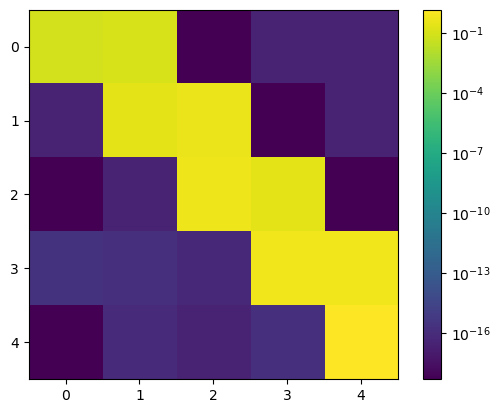

In [119]:
import matplotlib.pyplot as plt
import matplotlib.colors
A4 = reflect(A3, 4, [3, 4], 4)
A4 = reflect(A4.T, 4, [2, 3], 3).T
A4 = reflect(A4, 3, [2, 3], 3)
A4 = reflect(A4.T, 3, [1, 2], 2).T
A4 = reflect(A4, 2, [1, 2], 2)
A4 = reflect(A4.T, 2, [0, 1], 1).T
A4 = reflect(A4, 1, [0, 1], 1)
plt.imshow(np.abs(A4), norm=matplotlib.colors.LogNorm())
plt.colorbar()
A4

In [ ]:
# 